# Using Homomorphic Encryption to Implement An Encrypted Inference Service

While for some use cases in machine learning (ML) such as logistic regression, end-to-end homomorphic encryption (HE) is practicable, the added costs and constraints of purely encrypted operations limit its applicability to training larger neural network models. 

In this notebook, rather than using HE to train an end-to-end encrypted model, we will see how HE can be used to **enable encrypted inference using a normally trained model**.



## Motivation

Suppose that your organization has developed a neural network model that can accurately detect cancer in medical images. This model could be used as the basis for a service that enables end-users to privately submit medical images like microscopy slides, MRIs, or even raw images from a camera, and receive a private diagnosis for themselves or a patient.

The model was expensive to develop and is considered to be highly valuable intellectual property (IP). As such, your organization wants to protect the model from being distributed to directly users or leaked to competitors.

Additionally, some users (either patients or clinicians) are reluctant to send sensitive images to your organization unless there are strong privacy and security measures taken to protect their privacy and private data. 

In this scenario, HE can be used to **improve security for your organization** and to **improve certain aspects of privacy for users**. 





## System Overview

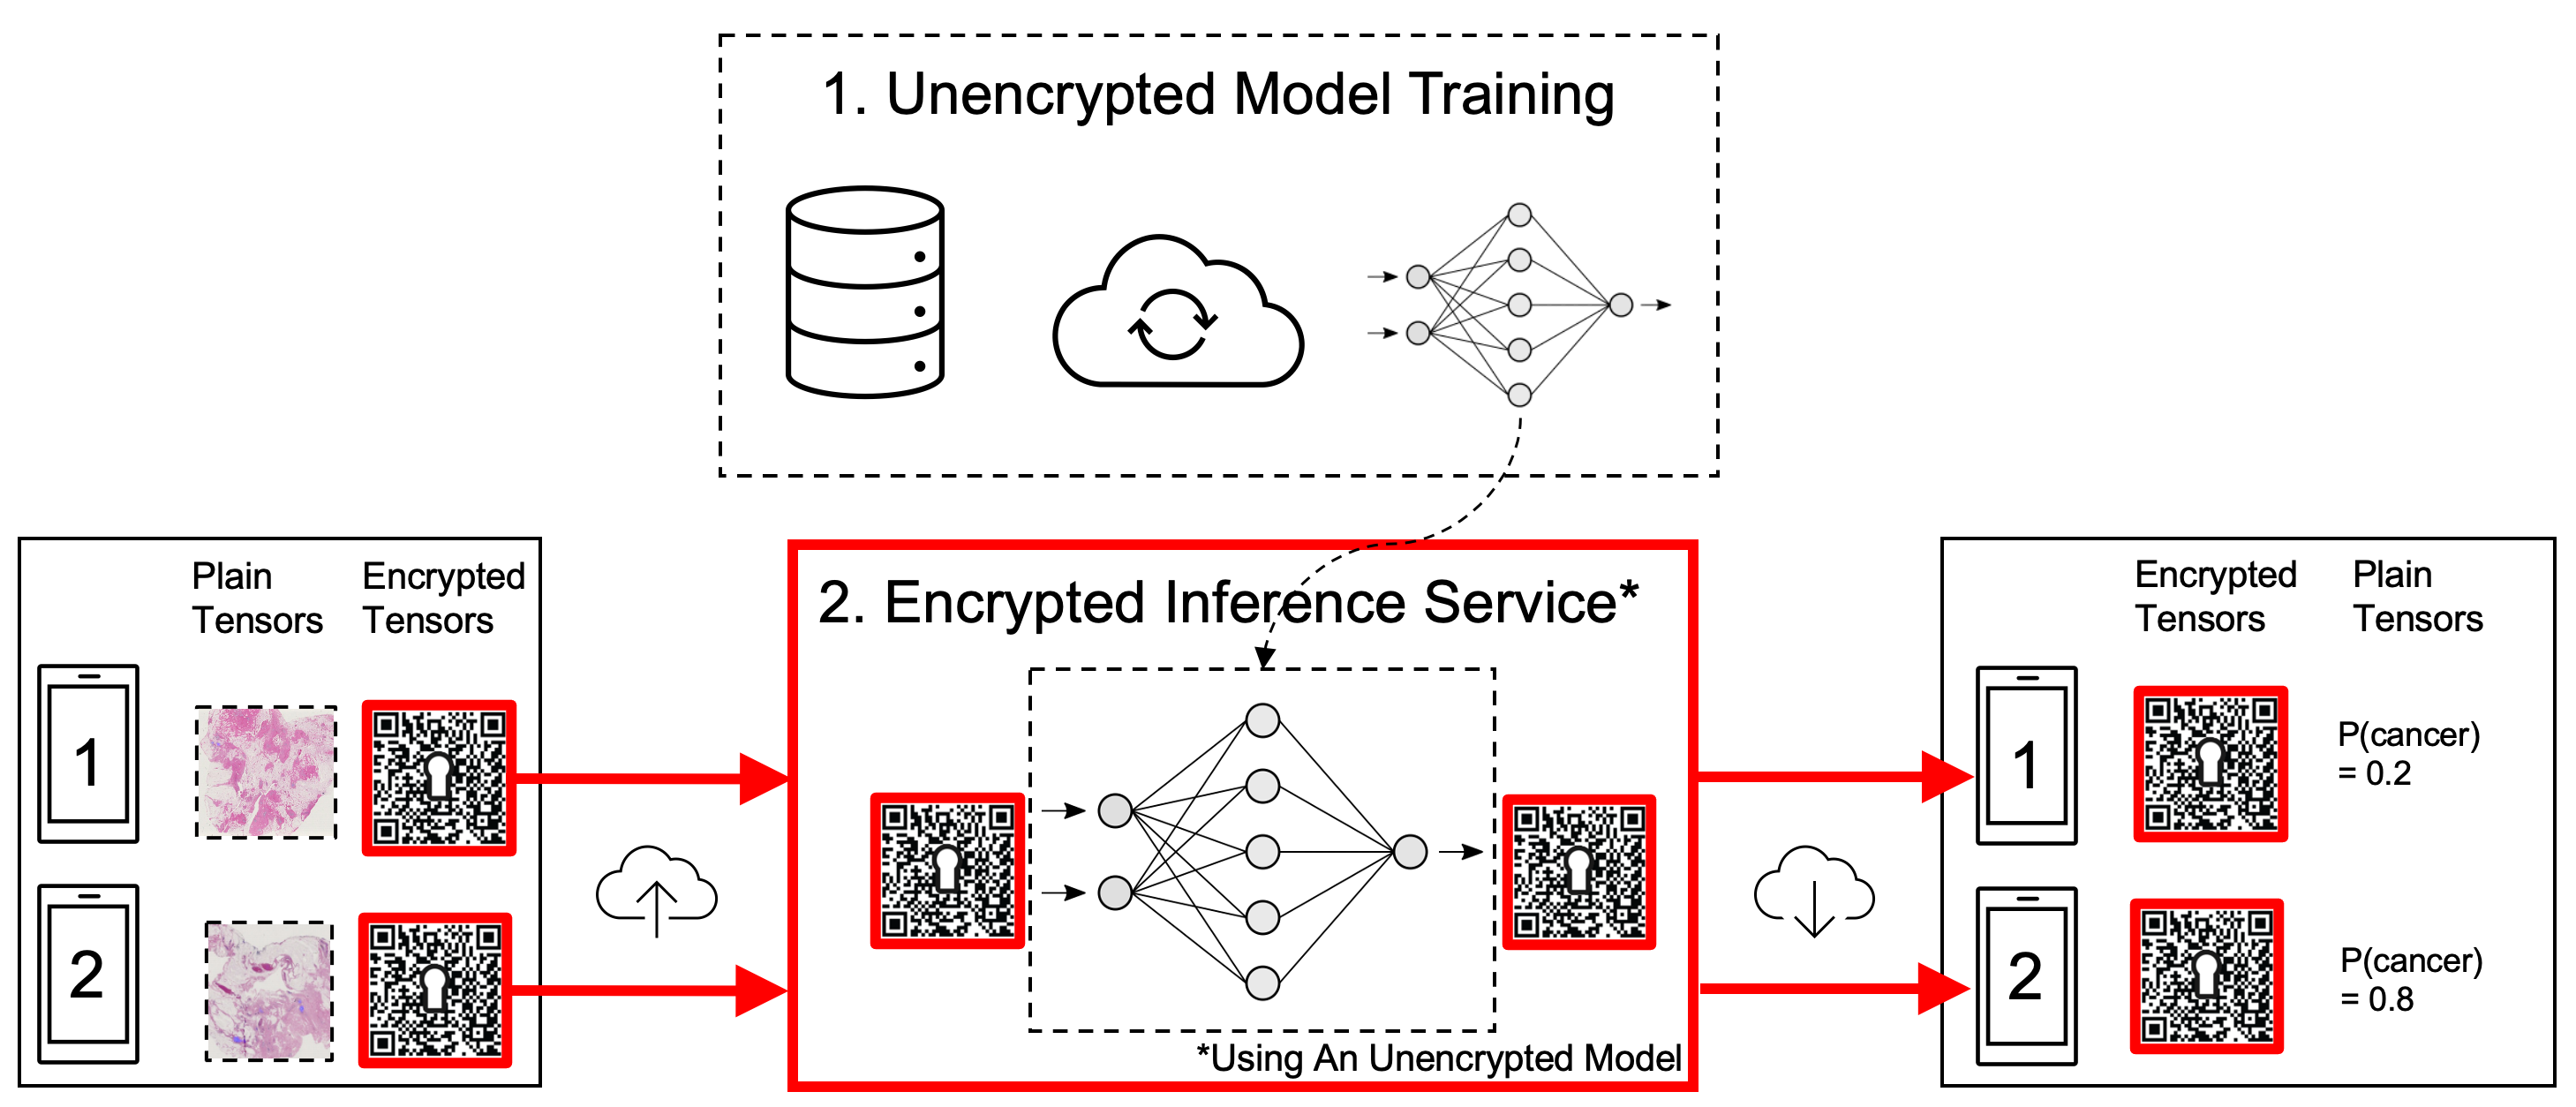

Due to the relatively heavy computational burden of using HE in ML, **this demo uses tablular data that have been extracted from images** rather than images directly. The efficient use of HE in applications of computer vision is an open area of research. The goal of this demo is to explore the use of HE, as implemented in the OpenMined package [TenSEAL](https://github.com/OpenMined/TenSEAL), at an approachable and useful level of abstraction. This demo adapts and extends some of their provided tutorials.

We use a free tabluar dataset for breast cancer prediction downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). Given a set of attributes extracted from images, the target is whether to predict whether the tumour sample is benign or malignant.

# 1. Unencrypted Model Training


## Imports

In [1]:
# !pip install tenseal

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tenseal as ts
import torch
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

## Load and Prepare Data

 

In [3]:
data_dir = "/ssd003/projects/pets/datasets"
all_data = pd.read_csv(f"{data_dir}/breast_cancer_data.csv").drop("Unnamed: 32", axis=1)
all_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
random_seed = 42

all_data["diagnosis"], _ = pd.factorize(all_data["diagnosis"])
all_data["diagnosis"] = (
    1 - all_data["diagnosis"]
)  # Flipping labels so that 0:benign and 1:malignant
label_index = pd.Index(pd.Series({0: "B", 1: "M"}))

all_data = all_data.astype(float)

train_data = all_data.sample(frac=0.8, random_state=random_seed)
valid_data = all_data.loc[~all_data.index.isin(train_data.index)]

train_y = train_data["diagnosis"].astype("int")
valid_y = valid_data["diagnosis"].astype("int")

train_x = train_data.drop(["diagnosis", "id"], axis=1)
valid_x = valid_data.drop(["diagnosis", "id"], axis=1)

In [5]:
class PandasDataset(Dataset):

    """
    Convenience class to take advantage of PyTorch DataLoaders
    """

    def __init__(self, X, y):
        assert len(X) == len(y), "X and y must have same length."
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X.iloc[idx].values, self.y.iloc[idx]

## Data Centering / Scaling

It is extra important to standard scale data in this example because the model
below uses an APPROXIMATE sigmoid that is only well-defined between -5 and 5. We'll see why this is necessary later.

In [6]:
scaler = StandardScaler()
scaler.fit(train_x)

train_x = pd.DataFrame(
    scaler.transform(train_x), index=train_x.index, columns=train_x.columns
).astype("float32")
valid_x = pd.DataFrame(
    scaler.transform(valid_x), index=valid_x.index, columns=valid_x.columns
).astype("float32")

train_ds = PandasDataset(train_x, train_y)
valid_ds = PandasDataset(valid_x, valid_y)

print(
    f"Training dataset size: {len(train_ds)} \tValidation dataset size: {len(valid_ds)}"
)

Training dataset size: 455 	Validation dataset size: 114


## Model Training

Define and train a simple, 2-layer MLP model. This model, trained using unencrypted data, will be used as the model for our encrypted inference services in [Section 2](#section2). 

In [7]:
batch_size = 64
torch.manual_seed(random_seed)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)


class MLP(torch.nn.Module):
    def __init__(self, input=30, hidden=16, output=2):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input, hidden).float()
        self.fc2 = torch.nn.Linear(hidden, output).float()

    @staticmethod
    def approx_sigmoid(x):

        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        # As such, data REALLY need to be standard scaled.

        return 0.5 + 0.197 * x - 0.004 * x ** 3

    def forward(self, x):
        x = self.fc1(x)
        x = self.approx_sigmoid(x)
        x = self.fc2(x)
        x = self.approx_sigmoid(x)
        return x


def train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10):

    # model in training mode
    model.train()

    for epoch in range(1, n_epochs + 1):

        # train
        train_loss = 0.0
        for data, target in train_loader:
            data = data
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)

        # validation
        with torch.no_grad():
            valid_loss = 0.0
            for data, target in valid_loader:
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()
            valid_loss = valid_loss / len(valid_loader)

        if epoch % 10 == 0:
            print(
                f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}"
            )

    # model in evaluation mode
    model.eval()
    return model


model = MLP(hidden=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
model = train(
    model, train_dataloader, valid_dataloader, criterion, optimizer, n_epochs=250
)

Epoch: 10 	Training Loss: 0.656752 	Validation Loss: 0.656996
Epoch: 20 	Training Loss: 0.607221 	Validation Loss: 0.616520
Epoch: 30 	Training Loss: 0.556237 	Validation Loss: 0.575293
Epoch: 40 	Training Loss: 0.517075 	Validation Loss: 0.525565
Epoch: 50 	Training Loss: 0.494239 	Validation Loss: 0.494420
Epoch: 60 	Training Loss: 0.455847 	Validation Loss: 0.477652
Epoch: 70 	Training Loss: 0.438397 	Validation Loss: 0.456469
Epoch: 80 	Training Loss: 0.438260 	Validation Loss: 0.440128
Epoch: 90 	Training Loss: 0.424460 	Validation Loss: 0.425837
Epoch: 100 	Training Loss: 0.404254 	Validation Loss: 0.418087
Epoch: 110 	Training Loss: 0.387909 	Validation Loss: 0.414094
Epoch: 120 	Training Loss: 0.383419 	Validation Loss: 0.399182
Epoch: 130 	Training Loss: 0.380462 	Validation Loss: 0.401198
Epoch: 140 	Training Loss: 0.381939 	Validation Loss: 0.394133
Epoch: 150 	Training Loss: 0.367905 	Validation Loss: 0.388920
Epoch: 160 	Training Loss: 0.370080 	Validation Loss: 0.386790
E

## Compute Evaluation Metrics

In [8]:
valid_xt = torch.Tensor(valid_x.values)
valid_yhat = model(valid_xt).argmax(dim=1).detach().numpy()

valid_accuracy = accuracy_score(y_true=valid_y, y_pred=valid_yhat)
valid_f1 = f1_score(y_true=valid_y, y_pred=valid_yhat)
print(
    f"Validation Accuracy: {valid_accuracy:.6f} \tValidation F1-Score: {valid_f1:.6f}"
)

Validation Accuracy: 0.956140 	Validation F1-Score: 0.943820


With the above accuracy and F1 scores, we are satisfied that the model has learned to predict the target reasonably well. We will use this model to implement our encrypted prediction service.

# 2. Encrypted Inference Service
<a name="section2"></a>

## Implementing An Encrypted Version of the Trained Model

We implement an encrypted version of the base MLP model by substituting PyTorch tensor operations with TenSEAL tensor operations. These are all mixed operations that ensure all computations are encrypted, despite the use of unencrypted model weights and biases. 


In [9]:
class EncryptedInferenceMLP(MLP):
    def __init__(self, base_mlp):

        super(EncryptedInferenceMLP, self).__init__()

        self.w1 = base_mlp.fc1.weight.data.T
        self.b1 = base_mlp.fc1.bias.data
        self.w2 = base_mlp.fc2.weight.data.T
        self.b2 = base_mlp.fc2.bias.data

    def forward(self, enc_x):
        enc_x = enc_x.matmul(self.w1) + self.b1
        enc_x = self.approx_sigmoid(enc_x)
        enc_x = enc_x.matmul(self.w2) + self.b2
        enc_x = self.approx_sigmoid(enc_x)
        return enc_x

    @staticmethod
    def approx_sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

Note that the choice of encryption parameters below can dramatically affect the precision and security of encrypted computations. Multiplications are particularly expensive in the sense that each operation consumes limited cryptographic resources, as per the CKKS protocol. An excellent overview of this protocol is given by one of its inventors in this [YouTube video](https://www.youtube.com/watch?v=iQlgeL64vfo). In the following example, **encryption parameters were determined experimentally** by increasing modulus sizes and degrees until encrypted inference was consistent with baseline model inference.

In [10]:
class PrivateClient:

    """
    Private user. Each user may "receive a sample" (e.g. a medical image) which should always
    be kept private once it leaves the client. The encrypted inference service should never
    be able to decrypt either the client data or the prediction generated for the client.
    """

    def __init__(self, user_id):

        # encryption parameters
        poly_mod_degree = 2 ** 14
        power = 30
        coeff_mod_bit_sizes = [40] + ([power] * 6) + [40]

        # create TenSEALContext
        ctx_eval = ts.Context(
            ts.SCHEME_TYPE.CKKS,
            poly_mod_degree,
            -1,
            coeff_mod_bit_sizes=coeff_mod_bit_sizes,
        )

        # scale of ciphertext to use
        ctx_eval.global_scale = 2 ** power

        # this key is needed for doing dot-product operations
        ctx_eval.generate_galois_keys()

        self.client_context = ctx_eval.copy()
        self.encryption_context = ctx_eval
        self.sample = None
        self.user_id = user_id
        self.enc_model_output = None

    def receive_sample(self, data):
        self.sample = data

    def encrypt_sample(self):
        assert self.sample is not None, "sample can not be None!"
        self.enc_sample = ts.ckks_vector(self.encryption_context, self.sample.tolist())
        self.sample = None
        self.encryption_context.make_context_public()

    def get_encrypted_sample(self):
        return self.enc_sample

    def get_private_sample(self):
        if self.sample is None:
            raise Exception("private_sample has been encrypted!")
        return self.sample

    def apply_model(self, model):
        self.enc_model_output = model(self.enc_sample)
        return self.enc_model_output

In [11]:
### Encrypted Inference Model ###

enc_inf_model = EncryptedInferenceMLP(model)

### Simulate Private Predictions ###

# n_users = len(valid_x)
n_users = 10
user_predictions = []

for index in range(n_users):
    user = PrivateClient(user_id=index)  # Initialize user w/ default encryption params
    user.receive_sample(valid_x.iloc[index])  # Receive/generate sample
    user.encrypt_sample()  # Encrypt the sample
    enc_prediction = user.apply_model(enc_inf_model)  # Apply model to encrypted sample
    enc_output = enc_prediction.decrypt(  # Decrypt model output using secret key
        secret_key=user.client_context.secret_key()
    )
    target_pred = np.argmax(enc_output)  # Generate cancer prediction
    user_predictions.append(target_pred)

    print(
        f"Prediction for User ID {user.user_id}: {label_index[target_pred]}, encrypted_output=[{enc_output[0]:.6f},{enc_output[1]:.6f}]"
    )

Prediction for User ID 0: M, encrypted_output=[-0.014432,1.019270]
Prediction for User ID 1: M, encrypted_output=[0.021355,0.987837]
Prediction for User ID 2: M, encrypted_output=[0.437133,0.583628]
Prediction for User ID 3: M, encrypted_output=[0.074344,0.936155]
Prediction for User ID 4: B, encrypted_output=[1.026612,-0.024628]
Prediction for User ID 5: B, encrypted_output=[0.987642,0.015859]
Prediction for User ID 6: M, encrypted_output=[0.001953,1.003658]
Prediction for User ID 7: M, encrypted_output=[-0.008741,1.013394]
Prediction for User ID 8: B, encrypted_output=[0.791368,0.223904]
Prediction for User ID 9: M, encrypted_output=[0.267607,0.749561]


In [12]:
### Baseline Model Comparison ###

valid_xt = torch.Tensor(valid_x.values)
valid_output = model(valid_xt).detach().numpy()
valid_yhat = model(valid_xt).argmax(dim=1).detach().numpy()

for index in range(n_users):

    target_pred = valid_yhat[index]
    print(
        f"Prediction for User ID {index}: {label_index[target_pred]}, output=[{valid_output[index][0]:.6f},{valid_output[index][1]:.6f}]"
    )

Prediction for User ID 0: M, output=[-0.014136,1.017212]
Prediction for User ID 1: M, output=[0.021769,0.984141]
Prediction for User ID 2: M, output=[0.437275,0.572748]
Prediction for User ID 3: M, output=[0.074871,0.930743]
Prediction for User ID 4: B, output=[1.026463,-0.025905]
Prediction for User ID 5: B, output=[0.988486,0.015621]
Prediction for User ID 6: M, output=[0.002329,1.000544]
Prediction for User ID 7: M, output=[-0.008456,1.011062]
Prediction for User ID 8: B, output=[0.790943,0.215205]
Prediction for User ID 9: M, output=[0.268024,0.740051]


In [13]:
### Unencrypted/Encrypted Validation Metrics ###

valid_yhat_enc = pd.Series(user_predictions)
valid_xt = torch.Tensor(valid_x.values)
valid_yhat = model(valid_xt).argmax(dim=1).detach().numpy()

valid_accuracy = accuracy_score(y_true=valid_y[:n_users], y_pred=valid_yhat[:n_users])
valid_f1 = f1_score(y_true=valid_y[:n_users], y_pred=valid_yhat[:n_users])

enc_valid_accuracy = accuracy_score(
    y_true=valid_y[:n_users], y_pred=valid_yhat_enc[:n_users]
)
enc_valid_f1 = f1_score(y_true=valid_y[:n_users], y_pred=valid_yhat_enc[:n_users])

print(
    f"Unencrypted Validation Accuracy: {valid_accuracy:.6f} \tUnencrypted Validation F1-Score: {valid_f1:.6f}"
)
print(
    f"Encrypted Validation Accuracy: {enc_valid_accuracy:.6f} \tEncrypted Validation F1-Score: {enc_valid_f1:.6f}"
)

Unencrypted Validation Accuracy: 0.900000 	Unencrypted Validation F1-Score: 0.933333
Encrypted Validation Accuracy: 0.900000 	Encrypted Validation F1-Score: 0.933333
